In [1]:
import numpy as np
import os
import time
import ica

from scipy.spatial.transform import Rotation as R
from scipy.ndimage import gaussian_filter
from functools import partial

import numpy as np
import multiprocessing as mp
import os
from tqdm import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('/data/users2/yxiao11/model/satellite_project')
from moduler_gen import *

In [2]:
def make_satellite_with_ids(color_list, color_to_material):
#     a, b, c = np.random.choice(np.arange(3, 19), 3, replace=False)
    color1 = color_list[np.random.randint(0, 45)] #body
    color2 = color_list[np.random.randint(45, 55)] #antenna
    
    color3 = color_list[np.random.randint(55, 65)] #connector
    color4 = color_list[np.random.randint(65, len(color_list))] #panel
    
#     color4 = color_list[0]
#     color2 = color_list[1]
#     color3 = color_list[2]
#     color1 = color_list[3]
    
    

    color1 = color1[:3] + [255]
    color2 = color2[:3] + [255]
    # color3 = color3[:3] + [255]
    color4 = color4[:3] + [255]

    components = []

    body = trimesh.creation.cylinder(radius=0.8, height=3.0, sections=20)
    body.visual.vertex_colors = np.tile(color1, (len(body.vertices), 1))
    components.append((body, color_to_material[tuple(color1[:3])]))

    antenna = trimesh.creation.icosphere(subdivisions=2, radius=0.7)
    antenna.apply_translation([0, 0, 1.5 + 0.8])
    antenna.visual.vertex_colors = np.tile(color2, (len(antenna.vertices), 1))
    components.append((antenna, color_to_material[tuple(color2[:3])]))

    connector1 = trimesh.creation.box(extents=[1.0, 0.3, 0.3])
    connector1.apply_translation([0.8 + 0.5, 0, 0])
    connector2 = trimesh.creation.box(extents=[1.0, 0.3, 0.3])
    connector2.apply_translation([-0.8 - 0.5, 0, 0])
    connectors = trimesh.util.concatenate([connector1, connector2])
    connectors.visual.vertex_colors = np.tile(color3, (len(connectors.vertices), 1))
    components.append((connectors, color_to_material[tuple(color3[:3])]))

    panel1 = trimesh.creation.box(extents=[3.5, 2.0, 0.01])
    panel1.apply_translation([3.0, 0, 0])
    panel2 = trimesh.creation.box(extents=[3.5, 2.0, 0.01])
    panel2.apply_translation([-3.0, 0, 0])
    solar_panels = trimesh.util.concatenate([panel1, panel2])
    solar_panels.visual.vertex_colors = np.tile(color4, (len(solar_panels.vertices), 1))
    components.append((solar_panels, color_to_material[tuple(color4[:3])]))

    satellite = trimesh.util.concatenate([body, antenna, 
                                          connectors, 
                                          solar_panels])

    return satellite, components

In [3]:
def generate_sample(fake_spectra, image_size=256, camera_h=25):
    
    
    
    # fake_spectra = generate_fake_spectra(data_type=data_type,
    #                                      material_path = material_path,
    #                                      num_spec=num_spec)
    
    color_list, color_to_material = generate_distinct_color_list(len(fake_spectra))
    
    _, components = make_satellite_with_ids(color_list, color_to_material)
    
    angles = np.random.randint(0, 360, 3)
    material_mask = rasterize_components_with_depth(components, image_size=image_size, camera_h=camera_h, angles=angles)
    
    
    spectral_cube, labels = create_spectral_cube((image_size, image_size), material_mask, fake_spectra)

    return material_mask,spectral_cube, labels

def simulator(image_size, fake_spectra, camera_h=10):
    
    material_mask,spectral_cube, labels = generate_sample(
        fake_spectra,
        # material_path = '/data/users2/yxiao11/model/satellite_project/material_spectral',
        image_size=image_size, 
        # data_type=data_type, 
        # num_spec=num_spec, 
        camera_h=camera_h
    )
    #######################
#     # Generate random k and b for each sample
#     k = np.random.uniform(0.7, 1.2)  # Example range for k
#     b = np.random.uniform(1, 3)      # Example range for b
    n_slices = spectral_cube.shape[0]
#     # Compute kernel sizes based on the linear formula
#     kernel_sizes = (k * np.arange(5,n_slices+5)/1 + b).astype(int)
#     kernel_sizes[kernel_sizes % 2 == 0] += 1  # Ensure odd kernel sizes
#     #######################
#     # Convert kernel sizes to corresponding sigmas
#     sigmas = kernel_sizes / 2.5  # Adjust this scaling factor as needed   

    sigmas = np.linspace(3.5e-7,2.5e-6,n_slices)
    sigmas = 0.25*sigmas/(3.6*5e-5)*1000
    blurred_cube = np.stack(
        [gaussian_filter(spectral_cube[j], 
                                       sigma=sigmas[j], 
                                       mode="mirror") for j in range(n_slices)], 
        axis=0
    ) 
    return material_mask,spectral_cube, blurred_cube, labels

In [56]:
# for i in range(num_spec):
#     plt.plot(fake_spectra[i])

In [4]:
data_type = 'Pristine'
num_spec = 100
fake_spectra = generate_fake_spectra(data_type=data_type,
            material_path='/data/users2/yxiao11/model/satellite_project/material_spectral/',
            num_spec=num_spec)

# Original list of keys (sorted numerically)
ids = sorted(fake_spectra.keys())

# Spectra matrix: shape (71, num_bands)
spectra_matrix = np.stack([fake_spectra[i] for i in ids], axis=0)

# Correlation matrix + sorting
corr_matrix = np.abs(np.corrcoef(spectra_matrix))
corr_strength = corr_matrix.sum(axis=1)
sorted_indices = np.argsort(-corr_strength)  # Descending

# Reorder original keys by correlation dominance
sorted_keys = [ids[i] for i in sorted_indices]
sorted_fake_spectra = {new_idx+1: fake_spectra[old_key] for new_idx, old_key in enumerate(sorted_keys)}

fake_spectra = sorted_fake_spectra

[23 53 60 67]


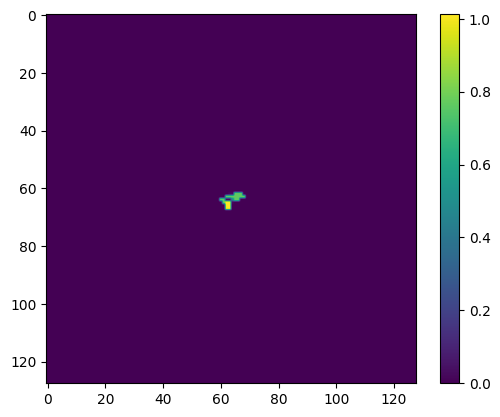

In [23]:
image_size = 128
material_mask, spectral_cube, blurred_cube, labels = simulator(image_size, fake_spectra, camera_h=100)
print(labels+1)
real_labels = labels+1
plt.imshow(spectral_cube[0])
plt.colorbar()

In [12]:
# nb = blurred_cube.reshape(num_spec,-1).T
# x,_,_ = ica.pca_whiten(nb, 50)
# for i,s in enumerate(x[30:]):
#     plt.plot(s, label=f'{i}')
# plt.legend()

In [ ]:
# plt.imshow(np.cov(spectral_cube[0:num_spec].reshape(num_spec,-1).T))

In [ ]:
# one_material = []
# for x in range(image_size):
#     for y in range(image_size):
#         if material_mask[x, y]==real_labels[2]:
#             one_material.append(blurred_cube[:,x,y][None

# plt.imshow(np.corrcoef(np.concatenate(one_material,0)))

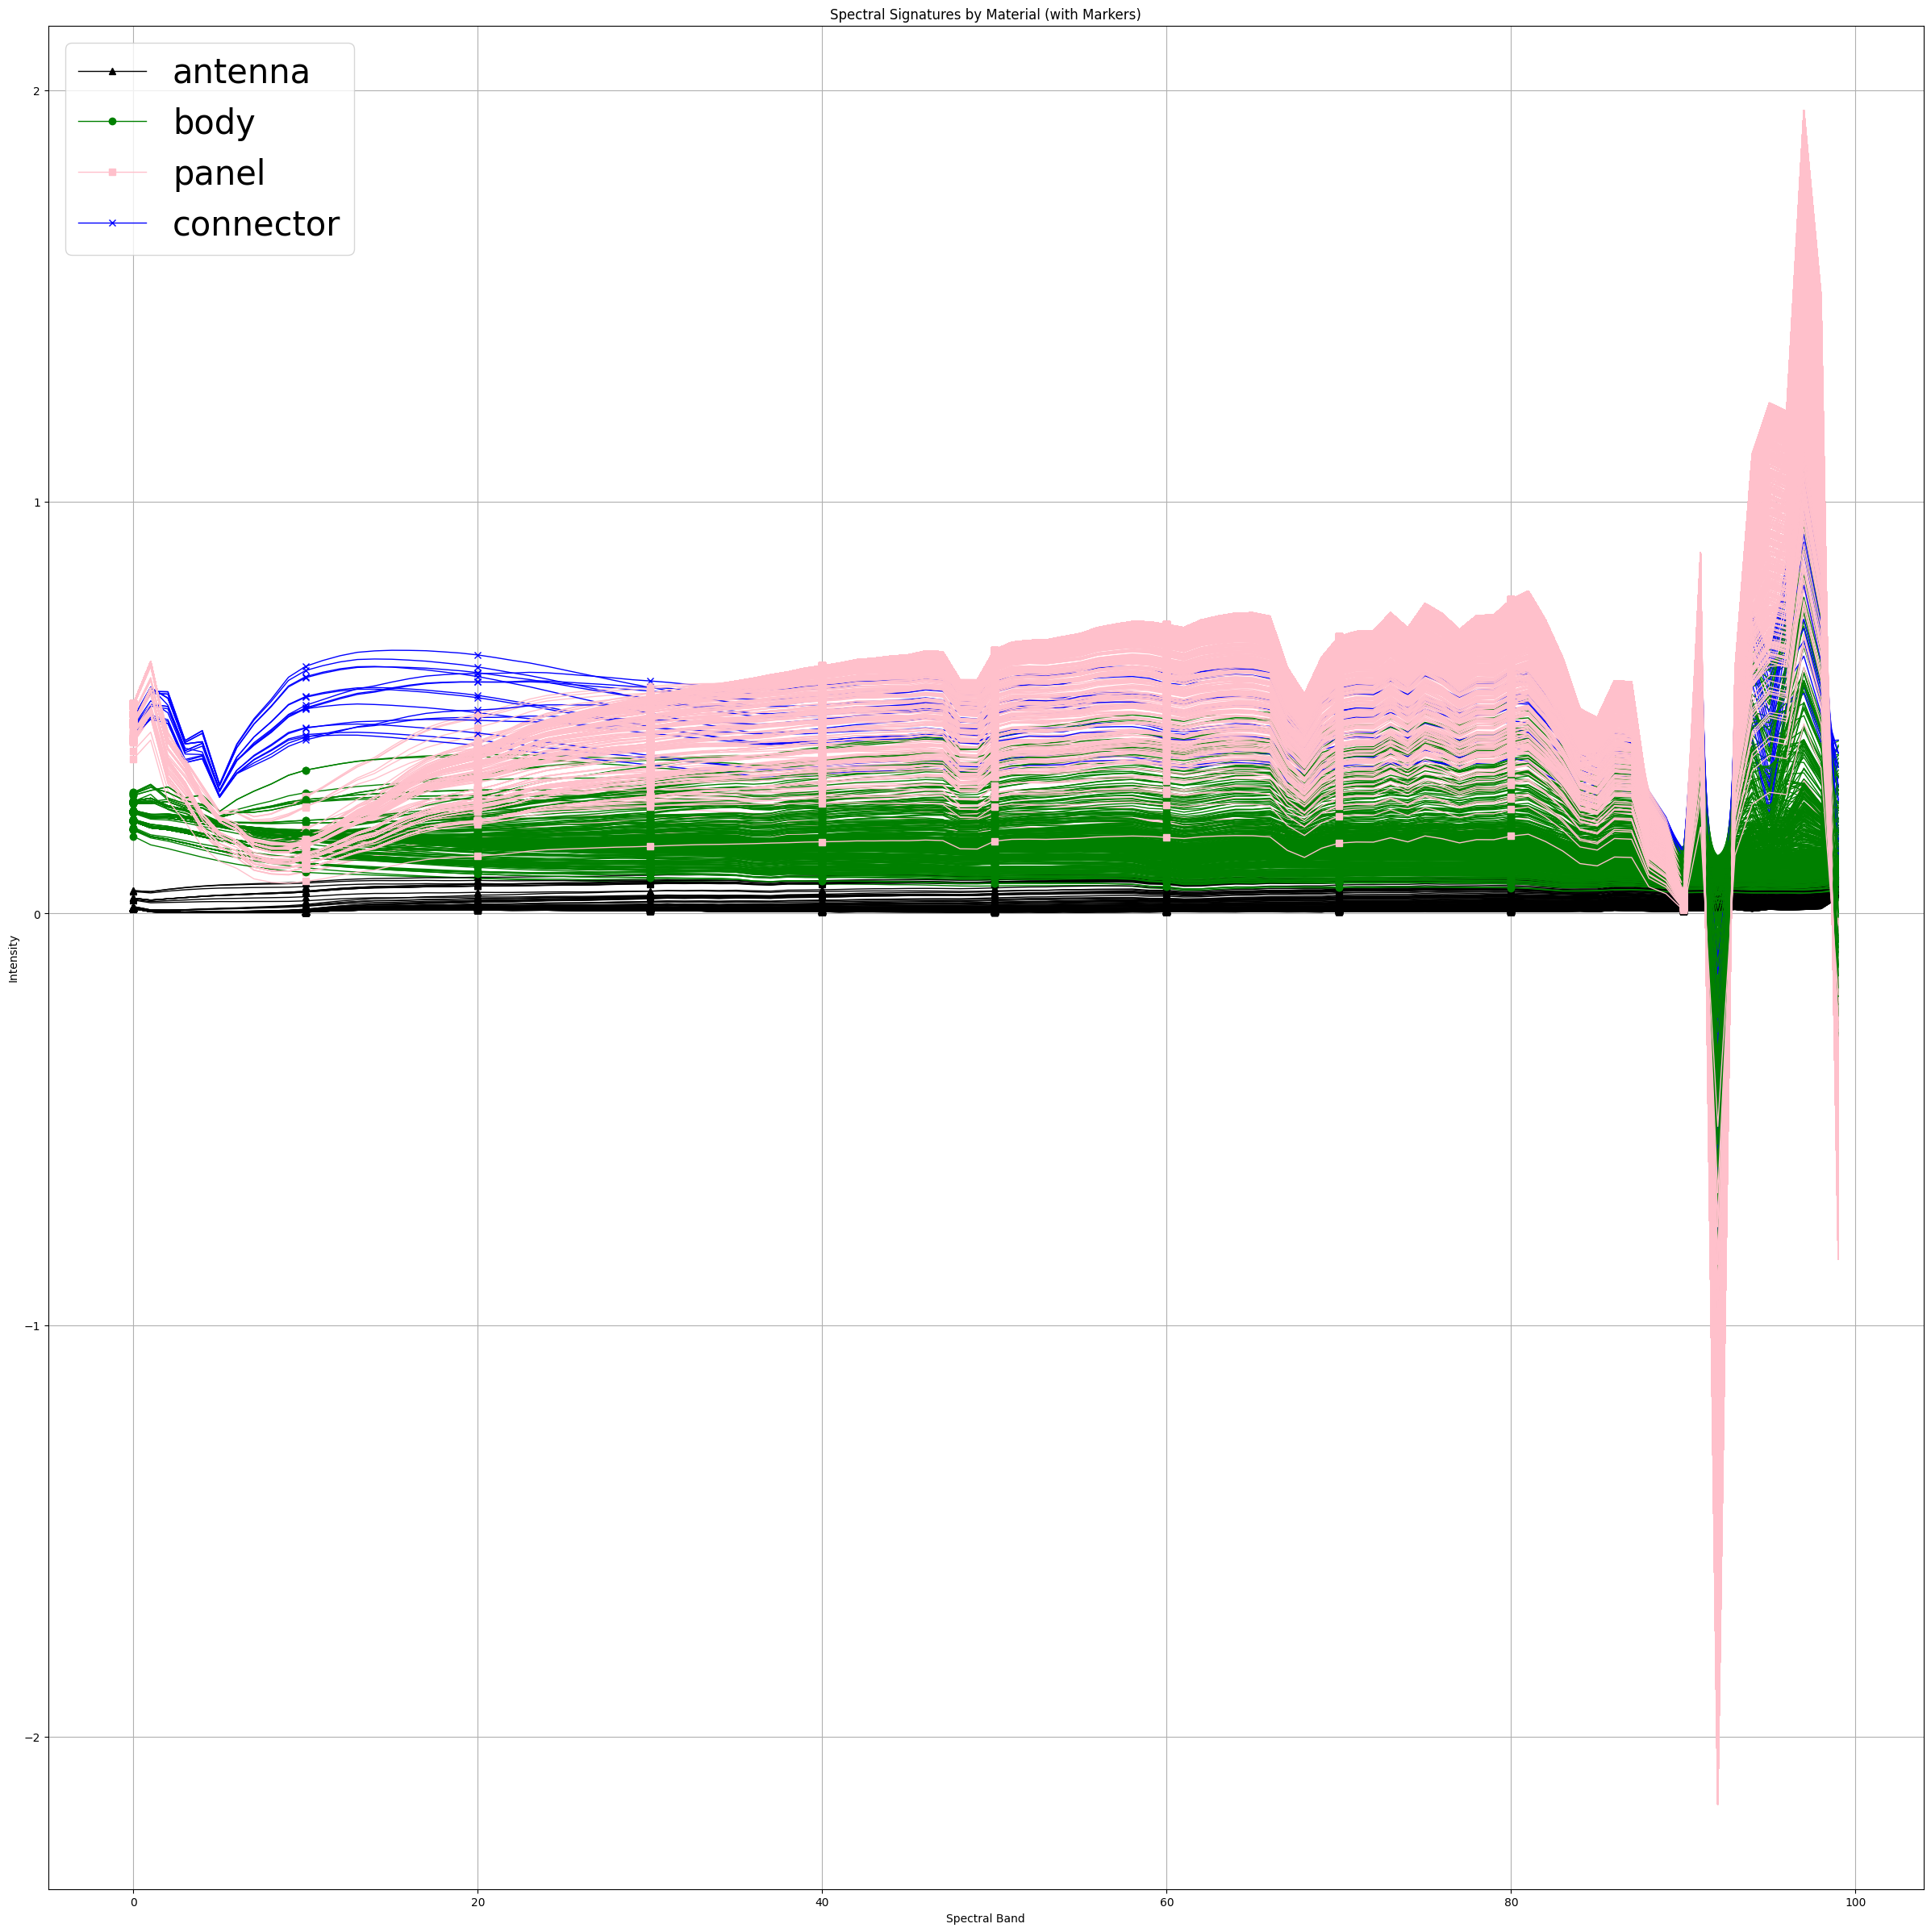

In [18]:
# ###############

plt.figure(figsize=(30, 30))

# Track used labels to prevent duplicates in legend
used_labels = set()

# Map: label_value → (color, label_text, linestyle or marker)
# Map: label_value → (color, label_text, linestyle or marker)
label_info = {}
for label in labels:
    if 0 <= label < 45:
            label_info[label+1] = ('green', 'body', 'o')
    if 45 <= label < 55:
        label_info[label+1] = ('black', 'antenna', '^')
    if 55 <= label < 65:
        label_info[label+1] = ('blue', 'connector', 'x')
    if 65 <= label < 71:
        label_info[label+1] = ('pink', 'panel', 's')

for x in range(image_size):
    for y in range(image_size):
        label_value = material_mask[x, y]
        if label_value in label_info:
            color, label, marker = label_info[label_value]
            y_values = blurred_cube[:, x, y][0:100]
            # First plot for this label: include legend
            if label not in used_labels:
                plt.plot(y_values, color=color, marker=marker, markevery=10, label=label, linewidth=1)
                used_labels.add(label)
            else:
                plt.plot(y_values, color=color, marker=marker, markevery=10, linewidth=1)

plt.xlabel("Spectral Band")
plt.ylabel("Intensity")
plt.title("Spectral Signatures by Material (with Markers)")
plt.legend(fontsize=30)
plt.grid(True)
plt.show()


In [ ]:
# image_size = 32
# pca_remain = 10
# spectral_cube, blurred_cube, labels = simulator(image_size, fake_spectra)
# x,_,_ = ica.pca_whiten(blurred_cube.reshape(num_spec,-1), pca_remain)
# print(labels)
# plt.imshow(x[0].reshape(image_size,image_size))

In [ ]:
# x=x.reshape(pca_remain,image_size,image_size)

In [ ]:
# x,y = np.where(material_mask==71)
# print(x)
# print(y)

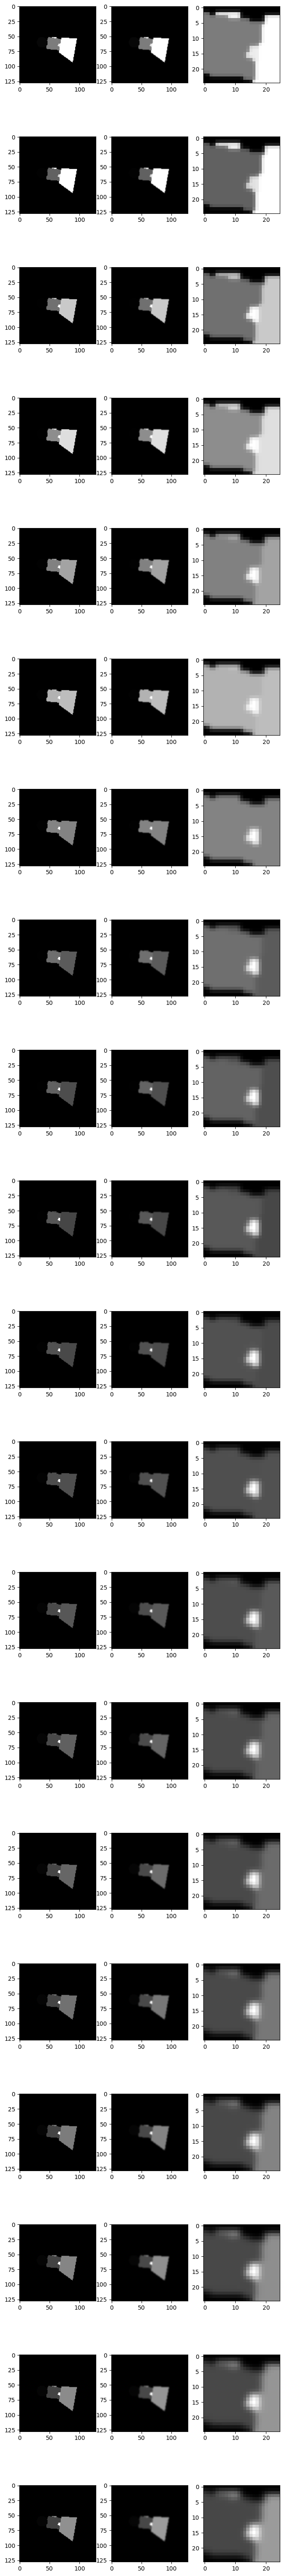

In [19]:
# row = pca_remain
row = 20
fig,ax = plt.subplots(row,3, figsize=(8,4*row))
for idx in range(row):
    ax[idx,0].imshow(spectral_cube[idx], 'gray')
    ax[idx,1].imshow(blurred_cube[idx], 'gray')
    ax[idx,2].imshow(blurred_cube[idx][50:75,50:75], 'gray')
#     ax[idx,1].imshow(x[-idx-1], 'gray')

In [ ]:
for i in range(10):
    material_mask, spectral_cube, blurred_cube, labels = simulator(image_size, fake_spectra)
    print(labels+1)
#     real_labels = labels+1
    # Track used labels to prevent duplicates in legend
    used_labels = set()

    # Map: label_value → (color, label_text, linestyle or marker)
    label_info = {}
    for label in labels:
#         if 0 <= label < 45:
#             label_info[label+1] = ('green', 'body', 'o')
        if 45 <= label < 55:
            label_info[label+1] = ('black', 'antenna', '^')
        if 55 <= label < 65:
            label_info[label+1] = ('blue', 'connector', 'x')
        if 65 <= label < 71:
            label_info[label+1] = ('pink', 'panel', 's')

    for x in range(image_size):
        for y in range(image_size):
            label_value = material_mask[x, y]
            if label_value in label_info:
                color, label, marker = label_info[label_value]
                y_values = blurred_cube[:, x, y][0:100]
                # First plot for this label: include legend
                if label not in used_labels:
                    plt.plot(y_values, color=color, marker=marker, markevery=10, label=label, linewidth=1)
                    used_labels.add(label)
                else:
                    plt.plot(y_values, color=color, marker=marker, markevery=10, linewidth=1)

    plt.xlabel("Spectral Band")
    plt.ylabel("Intensity")
    plt.title("Spectral Signatures by Material (with Markers)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
x = 14
y = 18

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(blurred_cube[:, x, y], label='Blurred Spectrum')
plt.subplot(1,2,2)
plt.plot(spectral_cube[:, x, y], label='Original Spectrum')

# plt.xlabel("Spectral Band")
# plt.ylabel("Intensity")
# plt.title("Spectral Comparison at Pixel (16, 16)")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
fig,ax = plt.subplots(30,4,figsize=(10,2*30))

for i in range(30):
#     ax[i,0].imshow(spectral_cube[i])
#     ax[i,1].imshow(blurred_cube[i])
    ax[i,0].imshow(spectral_cube[i])
    ax[i,1].imshow(blurred_cube[i])
    ax[i,2].plot(spectral_cube[i].flatten())
    ax[i,3].plot(blurred_cube[i].flatten())

In [ ]:
i = 0
blurred_cube = np.load(f'/data/users2/yxiao11/model/satellite_project/database/Pristine/blur_cube/{i}.npy')
spectral_cube = np.load(f'/data/users2/yxiao11/model/satellite_project/database/Pristine//spectral_cube/{i}.npy')

In [ ]:
l = len(spectral_cube)
fig, ax = plt.subplots(l,2, figsize=(4,200))

for i in range(l):
    ax[i,0].imshow(spectral_cube[i])
    ax[i,1].imshow(blurred_cube[i])

In [ ]:
# def get_material_id(data_type):
#     if data_type == "Pristine":
#         material_id = 1
#     elif data_type == "Irradiated":
#         material_id = 2
#     elif data_type == "mixed":
#         material_id = np.random.randint(1,3)
#     return material_id

# def generate_fake_spectra(data_type, bands_length = 50):
    
#     material_path = '/data/users2/yxiao11/model/satellite_project/material_spectral/'
#     file_names = os.listdir(material_path) # use 7 material, one don't know what it is
#     my_material_paths = []

#     my_dict_names = [name[:-5] for name in file_names]

# #     bands_length = 50
#     fake_spectra = {}


#     for material in my_dict_names:
#         path = os.path.join(material_path, material+'.xlsx')
        
#         s_names = pd.ExcelFile(path).sheet_names
                
#         if material == 'Thermal_paints': #8
#             material_id = get_material_id(data_type)
#             color_index = [10,11,12,13,14,15,4,7]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]        
        
#         if material == 'Kevlar': #1
#             material_id = get_material_id(data_type)
#             color_index = [5]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]        
        
#         if material == 'Polymers': #2
#             material_id = get_material_id(data_type)
#             color_index = [6,8]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]   
                
#         if material == 'Metals': #2
#             material_id = get_material_id(data_type)
#             color_index = [9,16]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]   
                
#         if material == 'Coverglasses': #3
#             material_id = get_material_id(data_type)
#             color_index = [17,18,19]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]
                
#         if material == 'Nomex': #3
#             material_id = get_material_id(data_type)
#             color_index = [1]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]
                
#         if material == 'Glass_Fiber_Reinforced_Polymer': #3
#             material_id = get_material_id(data_type)
#             color_index = [2]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]
                
#         if material == 'Tedlar': #3
#             material_id = get_material_id(data_type)
#             color_index = [3]
#             for i, s_n in enumerate(s_names):
#                 mt = pd.read_excel(path, sheet_name = s_n).iloc[:, material_id].tolist()[0:1024]
#                 fake_spectra[color_index[i]] = list_to_numpy_with_mean(mt)[::bands_length]
                
                
#     return dict(sorted(fake_spectra.items(), key=lambda x: x[0]))

# def make_satellite(color_list):
    
#     a,b,c = np.random.choice(np.arange(3,19),3,replace=False)
#     color1 = color_list[np.random.randint(0,3)]
#     color2 = color_list[a]
#     color3 = color_list[b]
#     color4 = color_list[c]
    
#     # 📌 Cylinder Body Parameters
#     body_height = 3.0
#     body_radius = 0.8
#     sections = 20  # Number of radial divisions

#     # 📌 Create the cylindrical body
#     body = trimesh.creation.cylinder(radius=body_radius, height=body_height, sections=sections)
#     body.visual.vertex_colors = color1  # Apply uniform color

#     # 📌 Create the antenna
#     antenna = trimesh.creation.icosphere(subdivisions=2, radius=0.4)
#     antenna.apply_translation([0, 0, body_height / 2 + 0.5])  # Position above the body
#     antenna.visual.vertex_colors = color2  # Apply color

#     # 📌 Create the connectors
#     connector_size = [1.0, 0.3, 0.3]  # [length, width, height]
#     connector1 = trimesh.creation.box(extents=connector_size)
#     connector1.apply_translation([body_radius + 0.5, 0, 0])
#     connector1.visual.vertex_colors = color3

#     connector2 = trimesh.creation.box(extents=connector_size)
#     connector2.apply_translation([-body_radius - 0.5, 0, 0])
#     connector2.visual.vertex_colors = color3

#     connectors = trimesh.util.concatenate([connector1, connector2])

#     # 📌 Create the solar panels
#     panel_size = [3.5, 2.0, 0.01]  # [length, width, thickness]
#     solar_panel1 = trimesh.creation.box(extents=panel_size)
#     solar_panel1.apply_translation([2.5, 0, 0])
#     solar_panel1.visual.vertex_colors = color4

#     solar_panel2 = trimesh.creation.box(extents=panel_size)
#     solar_panel2.apply_translation([-2.5, 0, 0])
#     solar_panel2.visual.vertex_colors = color4

#     solar_panels = trimesh.util.concatenate([solar_panel1, solar_panel2])

#     # 📌 Combine all parts into a single model
#     satellite = trimesh.util.concatenate([body, antenna, connectors, solar_panels])

#     return satellite


# def make_scene(satellite, image_size=256, camera_h = 25):
#     # Initialize the pyrender scene
#     scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0])  # Set uniform ambient light

#     # Add the satellite mesh to the scene
#     mesh = pyrender.Mesh.from_trimesh(satellite)
#     scene.add(mesh)

#     # Set flat materials for all primitives in the mesh
#     for node in scene.get_nodes():
#         if isinstance(node.mesh, pyrender.Mesh):
#             for primitive in node.mesh.primitives:
#                 primitive.material.baseColorFactor = [1.0, 1.0, 1.0, 1.0]  # Flat white color
#                 primitive.material.emissiveFactor = [1.0, 1.0, 1.0]  # Self-lit effect
#                 primitive.material.doubleSided = True
#                 primitive.material.alphaMode = "OPAQUE"

#     # Add a camera to view the scene
#     camera_pose = np.eye(4)
#     camera_pose[:3, 3] = [0, 0, camera_h]  # Position the camera
#     camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, znear=0.1, zfar=50.0)
#     scene.add(camera, pose=camera_pose)
    
#     return scene

# def render_with_rotation(scene, angles):
#     """
#     Render the scene with the model rotated around the origin and save the output image.
#     :param scene: Pyrender scene
#     :param angles: Tuple of (x, y, z) rotation angles in degrees
#     :param filename: Output file name for the rendered image
#     """
    

#     # Create a rotation matrix for the model
#     rotation_matrix = R.from_euler('xyz', angles, degrees=True).as_matrix()

#     # Create a 4x4 transformation matrix for the model
#     model_pose = np.eye(4)
#     model_pose[:3, :3] = rotation_matrix

#     # Find the mesh node in the scene (assuming only one node is the model)
#     mesh_node = [node for node in scene.get_nodes() if isinstance(node.mesh, pyrender.Mesh)][0]

#     # Apply the rotation to the model
#     scene.set_pose(mesh_node, pose=model_pose)
    
#     return scene

# def simulator(image_size, data_type="Pristine"):
    
#     satellite = make_satellite(color_list)
#     scene = make_scene(satellite, image_size)
    
#     os.environ["PYOPENGL_PLATFORM"] = "egl"
    
#     angle = np.random.randint(0,360, 3)
#     renderer = pyrender.OffscreenRenderer(viewport_width=image_size, viewport_height=image_size)
#     scene = render_with_rotation(scene, angle)
    

#     material_mask,labels = render_material_mask_with_tolerance(scene, renderer, color_to_material, tolerance=5)
#     renderer.delete()
    
#     # Combine 2D image and spectra to create a spectral cube
#     image_shape = (image_size, image_size)  # Example dimensions
    
#     fake_spectra = generate_fake_spectra(data_type, bands_length=20)
#     spectral_cube = create_spectral_cube(image_shape, material_mask, fake_spectra)
#     # Apply optical convolution
    
    
#     #######################

#     # Generate random k and b for each sample
#     k = np.random.uniform(0.7, 1.2)  # Example range for k
#     b = np.random.uniform(1, 3)      # Example range for b
#     n_slices = len(fake_spectra[1])
#     # Compute kernel sizes based on the linear formula
#     kernel_sizes = (k * np.arange(5,n_slices+5)/2.5 + b).astype(int)
#     kernel_sizes[kernel_sizes % 2 == 0] += 1  # Ensure odd kernel sizes

#     #######################
    
#         # Convert kernel sizes to corresponding sigmas
#     sigmas = kernel_sizes / 2.5  # Adjust this scaling factor as needed   

#     blurred_cube = np.stack(
#         [gaussian_filter(spectral_cube[:, :, j], 
#                                        sigma=sigmas[j], 
#                                        mode="mirror") for j in range(n_slices)], 
#         axis=-1
#     )
          
        
#     renderer = pyrender.OffscreenRenderer(viewport_width=800, viewport_height=800)
#     _,labels = render_material_mask_with_tolerance(scene, renderer, color_to_material)
#     labels = np.array(labels)
#     label = np.unique(labels)
# #     renderer.delete()

#     crop_size = 32
#     center_x, center_y = image_size // 2, image_size // 2  # Center coordinates

#     # Compute the cropping indices
#     start_x, end_x = center_x - crop_size // 2, center_x + crop_size // 2
#     start_y, end_y = center_y - crop_size // 2, center_y + crop_size // 2
    
#     return blurred_cube[start_x:end_x,start_y:end_y], spectral_cube[start_x:end_x,start_y:end_y], label

In [ ]:
import numpy as np
import pyrender
import trimesh
from scipy.spatial.transform import Rotation as R
os.environ['PYOPENGL_PLATFORM'] = 'egl'

image_size = 256

def render_with_rotation(scene, mesh_node, angles):
    """
    Rotate the mesh node around the origin and update its pose in the scene.
    :param scene: pyrender.Scene
    :param mesh_node: pyrender.Node that holds the mesh
    :param angles: Tuple of (x, y, z) rotation angles in degrees
    """
    # Create a rotation matrix
    rotation_matrix = R.from_euler('xyz', angles, degrees=True).as_matrix()

    # Create a 4x4 transformation matrix (pose)
    model_pose = np.eye(4)
    model_pose[:3, :3] = rotation_matrix

    # Apply the rotation to the mesh node
    scene.set_pose(mesh_node, pose=model_pose)

    return scene


# Generate satellite mesh
angles = np.random.randint(0, 360, 3)
satellite, components = make_satellite_with_ids(color_list)

# Initialize the scene
scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0])  # Uniform ambient light

# Add the satellite mesh to the scene and capture the node
mesh = pyrender.Mesh.from_trimesh(satellite)
mesh_node = scene.add(mesh)

# Set flat materials for all primitives (if they exist)
for node in scene.get_nodes():
    if node.mesh is not None:
        for primitive in node.mesh.primitives:
            primitive.material.baseColorFactor = [1.0, 1.0, 1.0, 1.0]
            primitive.material.emissiveFactor = [1.0, 1.0, 1.0]
            primitive.material.doubleSided = True
            primitive.material.metallicFactor = 0.0
            primitive.material.roughnessFactor = 1.0

# Add a camera to view the scene
camera_pose = np.eye(4)
camera_pose[:3, 3] = [0, 0, 10]  # Position the camera away from the origin
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, znear=0.1, zfar=50.0)
scene.add(camera, pose=camera_pose)

# Apply rotation and update the scene
scene = render_with_rotation(scene, mesh_node, angles)

# Set up the renderer
renderer = pyrender.OffscreenRenderer(viewport_width=image_size, viewport_height=image_size)

# Render the scene to color and depth
color, depth = renderer.render(scene)

# If you want to show the image using matplotlib
# import matplotlib.pyplot as plt
plt.imshow(color)
plt.xticks([])  # Removes x-axis ticks
plt.yticks([])
plt.show()

# Clean up the renderer
renderer.delete()